# **EE6132: Panoramic Stitching**



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_features

2. match_keypoints

3. find_homography and transform_ransac 

4. panoramic_stitching

# Starting the Assignment

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
# %matplotlib inline
# Importing required libraries
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

In [2]:
# %%capture
# ! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
# ! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualizing Input Images

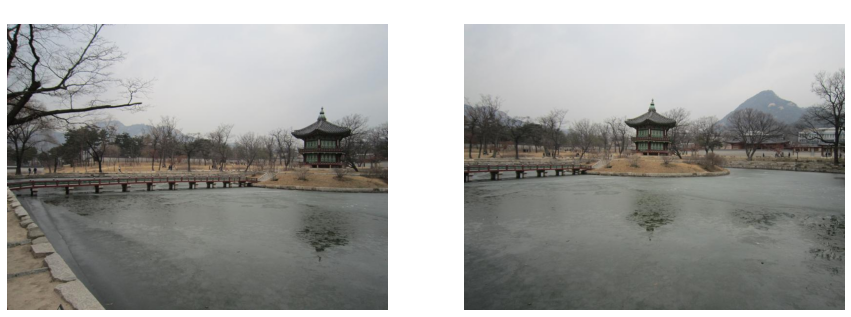

In [3]:
# Reading in the input images...
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_img(img, title=None):
    """
        Utility function to plot a large image in a (15,8) plot. 
        
        INPUTS : The image and a title (if needed)
        PLOTS : The input image
    """
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    if title is not None:
        plt.title(title, fontsize = 16, color='white')
    plt.yticks([]),  plt.xticks([])
    plt.show()

def plot_imgs(img1, img2, titles = None):
    """
        Utility function to plot two images side by side.
        
        INPUTS : The images img1 and img2, and the titles of the plots (if needed)
        PLOTS : The input images
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    for a in ax:
        a.set_axis_off()
    if titles:
        if len(titles)==2:
            ax[0].set_title(titles[0],fontsize = 16, color='white')
            ax[1].set_title(titles[1],fontsize = 16, color='white')
        else:
            raise ValueError("Please provide two titles for the two plots in a list!")
        
    ax[0].imshow(img1)
    ax[1].imshow(img2)

plot_imgs(img1, img2, ["Image1","Image2"])

# Computing SURF/ SIFT/ ORB Features and Matching Keypoints

- In the function `get_features()`, I used `cv2.SIFT_create()` to create the SIFT class object and then `SIFT.detectAndCompute()` to get the required keypoints and descriptors.
- I used SIFT here because it gave me a lot of good feature descriptors. SURF and ORB also give good features but they were comparatively less in number and not as accurate as SIFT. And also, the time complexity bottleneck in my implementation was the RANSAC algorithm so the extra time required to compute SIFT features was negligible in comparison.
- In `match_keypoints()` I then created a `cv2.BFMatcher` (BFM stands for Brute Force Matching) class object and used the computed keypoints and descriptors to match keypoints using `bf_obj.match()`. I used the L2_norm as the distance metric in this case because it worked quite well for me.
- I then sorted the matches in the ascending order of their distance (wrt the L2_norm) for ease of visualization.

In [4]:
def get_features(img):
    """
        Function to compute SURF/SIFT/ORB features using cv2 library functions. 
        Using default parameters when computing the keypoints.
        INPUT: 
              img - A cv2 image
        RETURNS:
              keypoints - a list of cv2 keypoints
              descriptors - a list of feature descriptors
    """
    # Creating the cv2 sift class object...
    sift_obj = cv2.SIFT_create()
    # Getting the keypoints and descriptors and returning them
    return sift_obj.detectAndCompute(img,None)

def match_keypoints(desc_1, desc_2):
    """
        Function to match keypoints using cv2 library functions.
        
        INPUTS : desc_1, desc_2 - list of feature descriptors
        RETURNS : matches - list of feature matches
    """
    # Creating a BFMatcher object using L2_Norm as the distance metric...
    bf_obj = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Matching the SIFT Feature descriptors ...
    matches = bf_obj.match(desc_1,desc_2)
    # Sorting the matches in the order of their distance (wrt the L2 norm) ...
    matches = list(sorted(matches, key = lambda x: x.distance))
    # Returning the required matches ...
    return matches

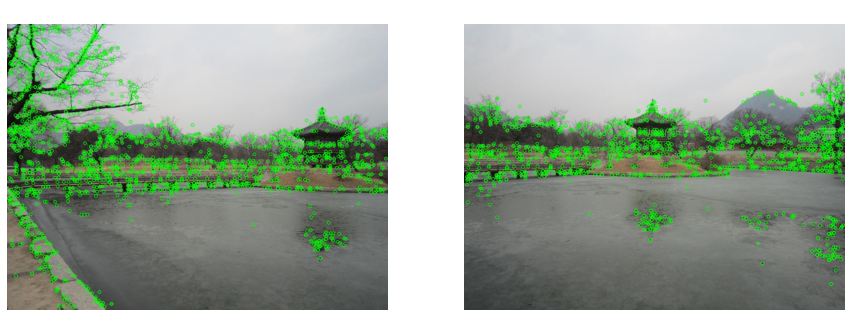

In [5]:
# Getting the keypoints and the feature descriptors..
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

# Visualizing the results using two images...
kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

# Plotting the images for observing the matches...
plot_imgs(kp_img1, kp_img2, ["Keypoints for Image 1", "Keypoints for Image 2"])

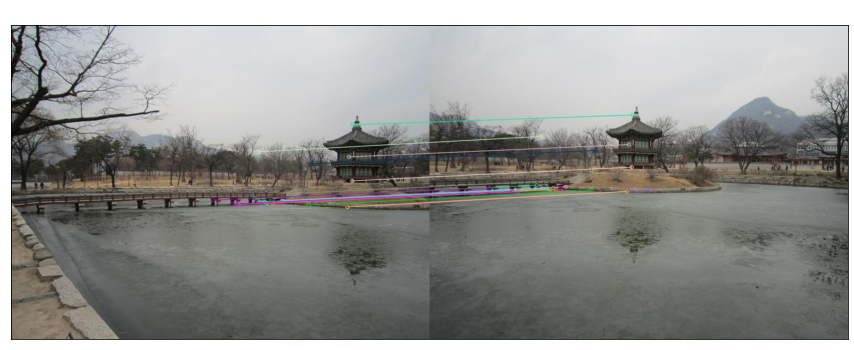

In [6]:
# Getting the feature matches using the feature descriptors...
matches = match_keypoints(desc_1, desc_2)
# Plotting the matches...
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)

plt.figure(figsize=(15,8))
plt.imshow(match_plot)
plt.title("Feature Matches", fontsize = 16, color='white')
plt.yticks([]),  plt.xticks([])
plt.show()

# Computing the Homography Matrix using RANSAC

- Here, the H matrix is computed using the DLT. First the **A** matrix is computed using the feature matches and then solved for the homography matrix **H** using Singular Value Decomposition(SVD).
- SVD for A is computed and the singular vector corresponding to the smallest singular value (of shape (1,9)) is then reshaped to (3,3) to give H.

In [7]:
def find_homography(pts_1, pts_2):
    """
        Function to implement the Direct Linear Transform (DLT) to find a homography that estimates the 
        transformation mapping from pts_1 to pts_2. e.g. If p1 is in pts_1 and p2 is in pts_2, then p2 = H * p1
        
        INPUTS:
              pts_1, pts_2 - (N, 2) matrices
        RETURNS:
              H - the resultant homography matrix (3 x 3)
    """
    # Checking to see if there are equal matches on either image...
    assert len(pts_1) == len(pts_2)
    
    # Storing the number of matches in N...
    N = len(pts_1)
    # Declaring an empty list to store the input matrix...
    A = []
    
    # Looping over the feature matches ...
    # The loop below uses tuple unpacking to get the coordinates directly.
    # The inbuilt zip() just puts together two lists horizontally (of sorts)
    for (x,y), (x1, y1) in zip(pts_1, pts_2):
        # Adding the rows corresponding to the coordinates (x,y), (x1, y1)
        # according to the DLT algorithm...
        A.append([-x, -y, -1, 0, 0, 0, x*x1,  y*x1, x1])
        A.append([0, 0, 0, -x, -y, -1, x*y1,  y*y1, y1])
    
    # Convering A to a numpy array (from a list) ...
    A = np.array(A)
    """
        Computing the Singular Value Decomposition of A using np.linalg.svd()...
        This returns three matrices U, S and V.
        
        We need the singular vector of the smallest singular value, but since 
        S is pre-sorted by numpy in descending order, we can just take the last 
        row of the hermitian of V as our H. 
        
        This is because we need the last column of V = last row of the transpose of V = last
        row of the hermitian of V since all the values in V are real given our input. 
    """
    _, S, Vh = np.linalg.svd(A)
    # Reshaping the required singular vector to get H, a (3,3) matrix...
    H = Vh[-1].reshape(3,3)
    # Actually, the H we obtain has L2_Norm = 1, so no need to normalize it here. 
    return H  # Returning H...

- Getting the point matches from the `cv2.DMatch` class object and storing them in `pts_1` and `pts_2` for points from images 1 and 2 respectively.

In [8]:
# Declaring two empty lists...
pts_1, pts_2 = [], []

# Looping through all feature matches...
for match in matches:
    # Appending the points in image1 to pts_1 and the points in image2 to pts_2
    pts_1.append(kp_1[match.queryIdx].pt)
    pts_2.append(kp_2[match.trainIdx].pt)

# Converting the lists to arrays...
pts_1, pts_2 = np.array(pts_1), np.array(pts_2)

## Scripting Utility functions for interconvertion between coordinate systems

- For converting a point **(x,y)** to homogeneous coordinates, we perform the following transformation: 
<br>
\begin{align}
\begin{bmatrix} x \\ y \end{bmatrix} \rightarrow \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{align}  <br>
- And for reconverting the point **(x',y',z')** to heterogeneous coordinates, we perform the following transformation: <br> <br> 
\begin{align}
\begin{bmatrix} x'\\y'\\z' \end{bmatrix} \rightarrow \begin{bmatrix} \frac{x'}{z'} \\ \frac{y'}{z'} \end{bmatrix}
\end{align}  <br>

In [9]:
def transform_Hetero(p):
    """
        Utility function to convert 2D homogeneous coordinates to 2D heterogeneous coordinates.

        INPUTS:
                The point p in 2D homogeneous coordinates (of length 3).
        RETURNS:
                The point p in 2D heterogeneous coordinates (of length 2).
    """
    if len(p) != 3:
        raise ValueError(f"p must be a list/array of length 3, not {len(p)}")
    
    # [x,y,z] -> [x/z, y/z]
    # round() is used for rounding off the point to the nearest integer.
    return [int(round(p[0]/p[2])), int(round(p[1]/p[2]))]


def transform_Homo(p):
    """
        Utility function to convert 2D heterogeneous coordinates to 2D homogeneous coordinates.

        INPUTS:
                The point p in 2D heterogeneous coordinates (of length 2).
        RETURNS:
                The point p in 2D homogeneous coordinates (of length 3).
    """
    # Checking to see if p is of length 2...
    if len(p) != 2:
        raise ValueError(f"p must be a list/array of length 2, not {len(p)}")
    
    # Unraveling p just to be on the safe side...
    p = list(np.array(p).ravel())
    # [x,y] -> [x,y,1], so appending 1 to p...
    p.append(1)
    # Returning the point p in 2D homogeneous coordinates...
    return p

- The Homography matrix obtained using all the points is not accurate due to some outliers. 
- We can observe this by transforming some points and checking the output.

In [10]:
# Finding H using all the matches...
H = find_homography(pts_1, pts_2)
print("The computed homography using all matched points:\n\n",H)

The computed homography using all matched points:

 [[ 4.35107031e-04  2.48591669e-03 -8.88821681e-01]
 [ 2.40641386e-04  1.31376036e-03 -4.58241883e-01]
 [ 7.84436813e-07  4.24216360e-06 -1.49757125e-03]]


In [11]:
# Storing model output...
p2_pred = np.abs(np.matmul(H, transform_Homo(pts_1[0])))
# Transforming p2_pred back to heterogeneous coordinates...
p2_pred = transform_Hetero(p2_pred)
print("Actual point : ",pts_2[0],"\nPredicted point : ",p2_pred)

Actual point :  [253.082901   301.30773926] 
Predicted point :  [503, 325]


- Clearly the prediction is **not accurate**.
- So, we use RANSAC to get the best estimate for the homography matrix.

## Scripting the RANSAC algorithm and code for visualization 

- The `drawMatches()` is used for visualizing the RANSAC algorithm by plotting the inliers. <br> <br>

- The **RANSAC** algorithm comprises of the following steps :
<ol>
  <li>Get four point correspondences (randomly)</li>
  <li>Compute H using Direct Linear Transform (DLT)</li>
  <li>Count inliers</li>
  <li>Keep H if largest number of inliers</li>
</ol> <br>
- Then we recompute H using all the inliers.

In [12]:
def drawMatches(img1, img2, inliers):
    """
       Function to visualize final inliers for the RANSAC algorithm.
       
       INPUTS: The images img1 and img2, and the list of inliers.
       RETURNS: The image with lines drawn between the inliers
    """
    # Checking to see if both the images are in color...
    if len(img1.shape) == 3 and len(img1.shape) == 3:
        
        # Storing the shapes of the input images
        r1, c1, _ = img1.shape
        r2, c2, _ = img2.shape
        
        """
            Creating a blank image of required shape.
            
            Note that the number of rows of the output image should not be so 
            small so that it does not cut out part of the larger image. Hence the 
            number of rows should be set to max(r1, r2).
            
            Also, the number of columns of the inputs are added to get the 
            number of columns for the output image. 
        """
    else:
        raise ValueError("NOTE : Both the input images need to be in color, the inputs given are not color images!")
    
    # If the images have the same shape, just stack them horizontally.
    # That is what np.hstack() does here
    if img1.shape == img2.shape:
        match_img = np.hstack([img1, img2])
    else:
        match_img = np.zeros((max([r1, r2]), c1+c2, 3), dtype=np.uint8)
        # Placing img1 to the left ...
        match_img[:r1, :c1, :] = img1
        # Placing img2 to the right of it ...
        match_img[:r2, c1:c1+c2, :] = img2

    # Lopping through all inliers...
    for inlier in inliers:
        
        # Getting the coordinates of the current inlier
        (x1, y1) = inlier[:2]
        (x2, y2) = inlier[2:]
        
        # Converting the coordinates to int (they were in float before)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Drawing a red circle at both coordinates using cv2.circle() ...
        cv2.circle(match_img, (x1, y1), 4, (255, 0, 0), -1)
        # Note that we need to add c1 to x2 as the images are side-by-side.
        cv2.circle(match_img, (x2+c1, y2), 4, (255, 0, 0), -1)

        # Drawing a green line in between the two inliers using cv2.line() ...
        cv2.line(match_img, (x1, y1), (x2+c1, y2), (0, 255, 0), 2)

    # Returning the image with matches.
    return match_img


def transform_ransac(pts_1, pts_2, thresh=5, N_iter = 400, verbose=False):
    """
        Function to implement RANSAC to estimate the homography matrix.

        INPUTS:
              pts_1, pts_1 - (N, 2) matrices.
              thresh - The preset threshold to score the model. Set to 5 by default.
              N_iter - The number of iterations to run the RANSAC loop. Set to 400 by default.
              verbose - Flag to visually check the output. Set to False by default
        RETURNS:
              best_model - The homography matrix with most inliers.
              best_inliers - The inliers for the best homography matrix.
    """
    
    # Checking to see if there are equal matches on either image...
    assert len(pts_1) == len(pts_2)
    
    # Storing the number of matches in N...
    N = len(pts_1)
    
    # Declaring placeholders for the best model and corresponding inliers...
    best_model, best_n_in = None, None

    # Running the loop N_iter times...
    for i in range(N_iter):
        """
            Getting four point correspondences randomly using np.random.choice(), which
            takes in an array and the size of the random choice, which is set to 4.
            Basically we get 4 random points from the N feature matches in each run. 
            We store these in sample_1 and sample_2 respectively (for img1 and img2).
        """
        sample_1, sample_2 = [], []
        # Getting the 4 random points...
        for p in np.random.choice(range(N), 4):
            sample_1.append(pts_1[p])
            sample_2.append(pts_2[p])
        
        # Finding the homography matrix using the four samples...
        H = find_homography(sample_1, sample_2)
        
        # If there is no best model till now, setting best model too the current one...
        if best_model is None:
            best_model = H
        
        """ 
            n_in stores the number of inliers for the current run.
            best_in stores the maximum number of inliers overall till now.
            inliers stores the inliers for the current run. 
        """
        n_in, best_in, inliers = 0, 0, []
        # Looping over all the feature matches to compute the number of inliers.
        for p1, p2 in zip(pts_1, pts_2):
            """
               Getting the current model prediction for the point p1.
               We first transform p1 to homographic coordinates and then mutiply 
               with H to get the prediction for p2 in homographic coordinates.
               I used np.abs() to be on the safer side.to force p2 to positive 
               as I got negative coordinates in some cases. 
            """
            p2_pred = np.abs(np.matmul(H, transform_Homo(p1)))
            # Transforming p2_pred back to heterogeneous coordinates...
            p2_pred = transform_Hetero(p2_pred)
            # Calculating the L2_Norm of p2-p2_pred to get the estimation error...
            # And if the error is less than the preset threshold, then the match
            # is an inlier.
            if np.linalg.norm(p2 - p2_pred) < thresh:
                # Updating the number of inliers.
                n_in += 1
                # Adding the inlier to the list. 
                inliers.append(list(p1)+list(p2))
        
        # Showing the status every 20 iterations if verbose flag is set
        if verbose and ((i+1)%20)==0:
            print("Iteration :", i+1, " | Max Inliers till now:", best_n_in)
        
        # If there are no best values set till now, setting the best values to the current values...
        if best_n_in is None:
            best_n_in = n_in
            best_inliers = inliers[:]
        
        # If we come across a better H, then upadting the best values...
        if best_n_in < n_in:
            best_model = H
            best_n_in = n_in
            best_inliers = inliers[:]
            
    # Converting the list of best inliers to an array...
    best_inliers = np.array(best_inliers,dtype=int)
    
    if verbose:
        print("\nComputing the best model using all inliers...")
    # Recomputing the best homography matrix using all inliers of the best model so far...
    best_model = find_homography(best_inliers[:,:2],best_inliers[:,2:])
    if verbose:
        print("\nDone!")
    # Returning the best RANSAC estimate for H and the best model inliers.
    return best_model, best_inliers

In [13]:
# Getting the best RANSAC estimate for H and the model inliers.
best_H, inliers = transform_ransac(pts_1, pts_2, verbose=True)

Iteration : 20  | Max Inliers till now: 315
Iteration : 40  | Max Inliers till now: 354
Iteration : 60  | Max Inliers till now: 354
Iteration : 80  | Max Inliers till now: 354
Iteration : 100  | Max Inliers till now: 396
Iteration : 120  | Max Inliers till now: 396
Iteration : 140  | Max Inliers till now: 396
Iteration : 160  | Max Inliers till now: 396
Iteration : 180  | Max Inliers till now: 396
Iteration : 200  | Max Inliers till now: 396
Iteration : 220  | Max Inliers till now: 397
Iteration : 240  | Max Inliers till now: 397
Iteration : 260  | Max Inliers till now: 397
Iteration : 280  | Max Inliers till now: 397
Iteration : 300  | Max Inliers till now: 397
Iteration : 320  | Max Inliers till now: 397
Iteration : 340  | Max Inliers till now: 397
Iteration : 360  | Max Inliers till now: 397
Iteration : 380  | Max Inliers till now: 397
Iteration : 400  | Max Inliers till now: 397

Computing the best model using all inliers...

Done!


In [14]:
print("The best homography matrix computed is:\n\n",best_H)

The best homography matrix computed is:

 [[ 3.25387222e-03  6.08746593e-06 -9.39762573e-01]
 [ 4.86768806e-04  2.85203266e-03 -3.41795504e-01]
 [ 1.79640892e-06  2.61573325e-07  1.78342710e-03]]


In [15]:
# Getting the percentage of points conforming to the best model..
print("Percentage of inliers for the best H model = ", np.round(len(inliers)*100/len(pts_1),1),"%")

Percentage of inliers for the best H model =  52.2 %


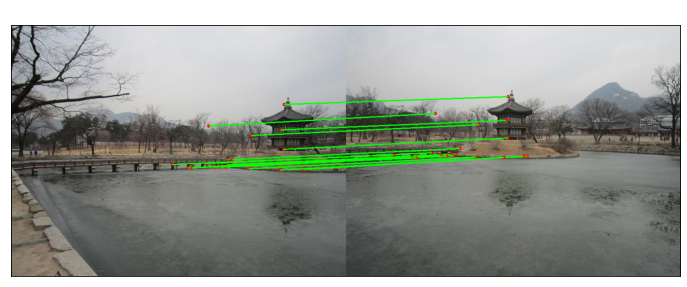

In [16]:
# Getting the plot of matches with the first twenty inliers 
# You can use any subset of the inliers for getting the plot.
match_plot = drawMatches(img1, img2, inliers[:20])

# Plotting the inliers...
plot_img(match_plot, "Some inliers of the best estimate of H using RANSAC")

# Panoramic Stitching (for two images)

- We first define the function `warpPerspective()` to transform an image to the perspective of another image using the computed homography matrix from RANSAC. 
- This does cut off some image pixels due to over-warping (some pixels go negative and other out of bounds) but the important features of the image are undisturbed. These pixels are cut-off.
- Also, the perspective transformation is done using inverse-mapping as suggested in the pdf. If we do not use this, then the output image has some "aliasing" which is unaesthetic. <br>
- For an even more aesthetically pleasing result, interpolation should be applied after the transformed point is obtained but I have no implemented it because there was no mention of this in the pdf.

**THE REASON WHY ALIASING OCCURS WHEN INVERSE-MAPPING IS NOT USED**:<br><br>
- This is because when you transform the input image to the perspective of another image using homographic transformation, since we are not using interpolation here (but just rounding the pixel location off to integers), we get some blank (i.e black) pixels at some points of the output image where no pixels from the input image map to. <br><br>
- I am not sure if the correct term for this is "aliasing", but the effects are similar, so I'll stick to it.<br><br>
- To mitigate this effect, "inverse-mapping" is used where we first create a blank image (for storing output), iterate over the pixels of the blank image, use the homography matrix (technically its inverse $H^{-1}$ should be used, but here I used $H$ directly since I computed the homography matrix using the feature matches in such a way that inverse is not required) to get the point in the image whose color (or color channel's values) should be set to the blank point and then set it if it is within the bounds of the image.<br><br>
- In this way, every pixel in the **warped image is colored uniformly**. Bear in mind that we again do not use any interpolation here, but round off the pixel values like we did earlier. However, the rounding off is done to a location in the image which has color and this is set to the blank image pixel. So, every point which should be colored in the warped image gets colored and **no aliasing effects are observed**. 

**PLEASE NOTE** : <br>
- There is some discrepancy when addressing an image pixel as `image[x,y]` between numpy and OpenCV. <br>
- When I say `(x,y)` here, `x` refers to the horizontal coordinate, while `y` refers to the vertical coordinate. <br>
- OpenCV computes the image keypoints and matches in the form of `(x,y)`, but to access image pixels directly using numpy it should actually be accessing like `(y,x)`.  <br>
- Since the homography is computed using the keypoint matches from OpenCV, it transforms the image in a similar fashion.<br>
- So, I iterated over all pixels to convert each pixel to homogeneous coordinates, multiplied with the homography matrix and reconvert back to heterogeneous coordinates get the pixel's location after the perspective transformation. But this is in the form `(x,y)` as mentioned before, so I accessed the image pixel using the form `(y,x)` as before (I will mentioned t which point in the comments).<br>
- Also note that the final image will be in a transposed form, I took the transpose of the final image wrt the first two dimensions (as the RGB pixel order should not be perturbed) using `np.einsum('ijk->jik', final_image)` which does this in a single step. <br>
- Note that I cannot use the usual method of `np.array.T` to get the transpose as this only works for 2D arrays (but the image has color channels too)<br>
- I also noticed that without doing it like this, part of the image gets cutoff and the output looks weird. Or some aliasing effects occur. This method gave me the best output so I stuck to it.

In [17]:
def warpPerspective(img, H, dsize):
    """
        Function to generate a panoramic image using the given homography matrix.

        INPUTS: 
              img - The image which to be transformed
              H - The homography matrix of shape (3,3)
              dsize - The size of the output, expressed as a tuple - (rows,columns)
        RETURNS:
              warp - The image after perspective transformation.
    """
    
    # Storing the number of rows and columns for ease...
    nR, nC = dsize
    # Creating a blank image to store the warped image...
    warp = np.zeros((nR, nC, img.shape[2]),dtype=np.uint8)
    
    # Looping over the pixels for warp...
    # Note that we use inverse mapping here to avoid aliasing effects as explained earlier.
    for x in range(nR):
        for y in range(nC):
            """
                Getting the warped point in homogeneous coordinates...
                transform_Homo() is pretty straightforward, pls check documentation.
                np.matmul(mat1, mat2) is used for matrix multiplication
            """
            p = np.matmul(H, transform_Homo([x, y]))
            # Reconverting back to heterogeneous coordinates...
            # The transform_Hetero() rounds the pixels off to integers as floating point indexes are not allowed.
            # Since this refers to a location in the image, aliasing effects are not observed...
            i, j = transform_Hetero(p)
            # Cutting of pixels which are out of bound...
            if 0 <= i < img.shape[1] and 0 <= j < img.shape[0]:
                # Storing the pixel in the warped image...
                # Also, recall that I mentioned before that I access the image 
                # pixel using the form (y,x), this is where I do it 
                # (by indexing the point img[j,i] instead of img[i,j].)
                warp[x, y] = img[j, i]
    
    # Also, I mentioned before that the warped image is transposed, so
    # taking the transpose again using np.einsum(). Reason explained before.
    warp = np.array(np.einsum("ijk->jik", warp), dtype=np.uint8)
    
    # Returning the warped output...
    return warp

- NOTE : I am setting the RANSAC threshold for H really low at `0.5` (as compared to `thresh=5` used before) for the stitching process.
- I found that this gives a much better estimate for H (albeit having lower inlier ratio).
- The perspective transformation quality improves if thresh is set low (due to a better estimate of H).

In [18]:
def panoramic_stitching(img1, img2, verbose=False):
    """
        Function to generate a panoramic image using the obtained homography matrix.

        INPUTS: 
              img1, img2 - cv2 images
              verbose - Flag to check the algorithm's runtime visualizations. Set to False by default
        RETURNS:
              final_img - The image of the stitched panorama
    """

    # Getting the keypoints and the feature descriptors of both images...
    kp_1, desc_1 = get_features(img1)
    kp_2, desc_2 = get_features(img2)
    
    if verbose:
        # Visualizing the results using two images if verbose is set...
        kp_img1 = cv2.drawKeypoints(
            img1, kp_1, None, color=(0, 255, 0), flags=0)
        kp_img2 = cv2.drawKeypoints(
            img2, kp_2, None, color=(0, 255, 0), flags=0)

        # Plotting the images for observing the matches...
        plot_imgs(kp_img1, kp_img2, [
                  "Keypoints for Image 1", "Keypoints for Image 2"])

    # Getting the feature matches using the feature descriptors...
    matches = match_keypoints(desc_1, desc_2)
    
    # Plotting the matches if verbose is set...
    if verbose:
        match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
        plot_img(match_plot, "Feature Matches")
    
    # Declaring two empty lists...
    pts_1, pts_2 = [], []

    # Looping through all feature matches...
    for match in matches:
        # Appending the points in image1 to pts_1 and the points in image2 to pts_2
        pts_1.append(kp_1[match.queryIdx].pt)
        pts_2.append(kp_2[match.trainIdx].pt)

    # Converting the lists to arrays...
    pts_1, pts_2 = np.array(pts_1), np.array(pts_2)
    
    print("Computing the best homography matrix H using RANSAC...")
    # Getting the best RANSAC estimate for H and the model inliers.
    best_H, inliers = transform_ransac(pts_1, pts_2, thresh=0.5, verbose=verbose)
    print("\nDone! The best estimate for H : \n\n",best_H)
    
    if verbose:
        # Getting the plot of matches with the first twenty inliers
        # You can use any subset of the inliers for getting the plot.
        match_plot_2 = drawMatches(img1, img2, inliers[:20])
        plot_img(match_plot_2, "Some inliers of the best estimate of H using RANSAC")
    
    print("\nWarping the second image to the perspective of the first image...")
    # I am setting a final image size of (img1.shape[1]+img2.shape[1]-100), img2.shape[0]+200)
    # by trial and error. Some other values work too.
    final_img = warpPerspective(img2, best_H, ((img1.shape[1]+img2.shape[1]-100), img2.shape[0]+200))
    print("\nPerspective transformation complete! Stitching the images...")
    # Plotting the image after perspective transformation if verbose is set...
    if verbose:
        plt.imshow(final_img)
        plt.title("Image2 after warping", fontsize=16, color='white')
        plt.xticks([]), plt.yticks([])
        plt.show()
    
    # Storing the first image in final_img to get the stitched panorama...
    final_img[0:img1.shape[0], 0:img1.shape[1]] = img1
    
    # Returing the stitched panorama...
    return final_img

Computing the best homography matrix H using RANSAC...

Done! The best estimate for H : 

 [[-3.22410530e-03  1.74773672e-05  9.31920829e-01]
 [-5.19417844e-04 -2.81114229e-03  3.62632384e-01]
 [-1.90065755e-06 -2.94186079e-07 -1.65995797e-03]]

Warping the second image to the perspective of the first image...

Perspective transformation complete! Stitching the images...


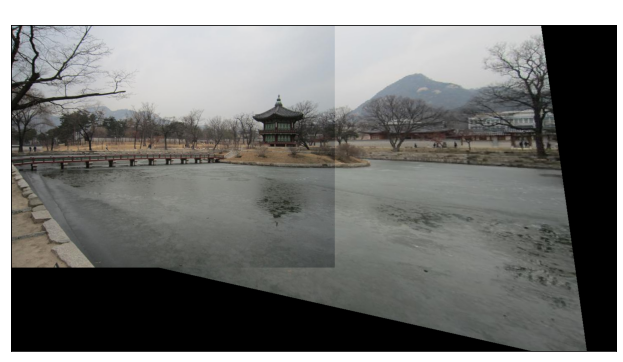

In [19]:
# Getting the stitched image and plotting it...
result = panoramic_stitching(img1, img2)
plot_img(result, "The Final Stitched Panorama")

# Panoramic Stitching (for three images)

In [20]:
# Reading in the input images...
img1 = plt.imread('Data/image1.jpg')
img2 = plt.imread('Data/image2.jpg')
img3 = plt.imread('Data/image3.jpg')

# Reading in the reference image...
ref = plt.imread('Data/Reference/panorama.jpg')

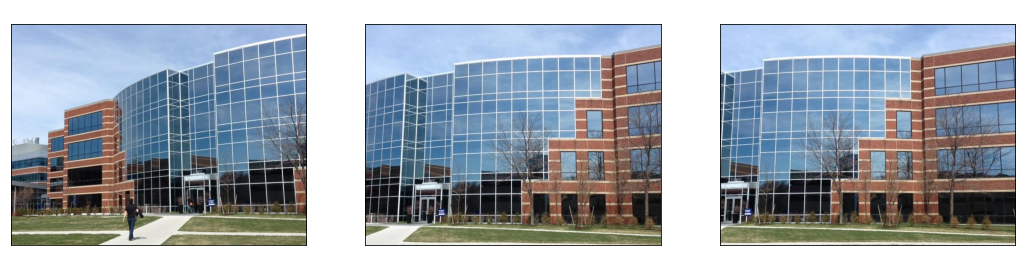

In [21]:
def plot_three_imgs(img1, img2, img3, titles=None):
    """
        Utility function to plot three images side by side.
        
        INPUTS : The images img1, img2 and img3, and the titles of the plots (if needed)
        PLOTS : The input images
    """
    # Setting output figure size...
    plt.figure(figsize=(18,5))
    # Iterating 3 times...
    for i in range(3):
        plt.subplot(1,3,i+1)
        # exec() just executes whatever is there in the string.
        # Check internet for more explanation.
        exec(f'plt.imshow(img{str(i+1)})')
        if titles!=None:
            plt.title(titles[i], fontsize=14, color='white')
        plt.xticks([]), plt.yticks([])
        
    plt.show()

# Plotting the input images for checking...
plot_three_imgs(img1, img2, img3, ["Input image 1","Input image 2","Input image 3"])

In [22]:
def crop_Black(image):
    """
        Utility function to crop out the black borders of an image.
        
        INPUT: 
              A cv2 Image.
        RETURNS: 
              The image with black borders cropped out.
    """
    # Getting the image boundaries using np.nonzero()...
    # np.nonzero() returns all the indices of the elements that are non-zero
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    # Returning the cropped image
    # Note: The minimum and maximum of the non-zero elements define the image boundaries.
    # The rest are just unnecessary black pixels so can be cropped out.
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

- As mentioned in the pdf, I am taking image 2 as the reference for images 1 and 3. <br> <br> 
- **IMPORTANT NOTE** : The reason why I took the inverse of images 1 and 2 wrt the y-axis (or column inversion) to compute the feature matches, homography matrix and then warped the images, stitched them together and inverted wrt y-axis to get the correct orientation again was because a lot of points were getting cut-off if I directly warped image1 to the perspective of image2. But this did not occur after the column inversion. <br> <br> 
- Also, I set the threshold of inliers for RANSAC very low (I used `thresh=0.3`) to get an even more accurate and precise H. I did work out.

In [23]:
def panoramic_stitching_multiple(img1, img2, img3, verbose=False):
    """
        Function to generate a panoramic image using three input images.

        INPUTS: 
              img1, img2, img3 - cv2 images
              verbose - Flag to check the algorithm's runtime visualizations. Set to False by default
        RETURNS:
              final_img - The image of the stitched panorama
    """
    
    # Getting the keypoints and the feature descriptors...
    kp_1, desc_1 = get_features(img1)
    kp_2, desc_2 = get_features(img2)
    kp_3, desc_3 = get_features(img3)

    # Visualizing the results using three images if verbose is set...
    if verbose:
        
        kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0, 255, 0), flags=0)
        kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0, 255, 0), flags=0)
        kp_img3 = cv2.drawKeypoints(img3, kp_3, None, color=(0, 255, 0), flags=0)
        
        # Plotting the images for observing the matches...
        plot_three_imgs(kp_img1, kp_img2, kp_img3, [
                  "Keypoints for Image 1", "Keypoints for Image 2", "Keypoints for Image 3"])

    # Getting the feature matches using the feature descriptors...
    matches_1_2 = match_keypoints(desc_1,desc_2)
    matches_3_2 = match_keypoints(desc_3,desc_2)
    
    if verbose:
        # Plotting the matches for image1 and image2 ...
        match_plot_1_2 = cv2.drawMatches(img1, kp_1, img2, kp_2,matches_1_2[:20], None, flags=2)
        # Plotting the matches for image3 and image2...
        match_plot_3_2 = cv2.drawMatches(img3, kp_3, img2, kp_2,matches_3_2[:20], None, flags=2)
        plot_img(match_plot_1_2,  "Some Feature Matches for Images 1 and 2")
        plot_img(match_plot_3_2,  "Some Feature Matches for Images 3 and 2")
    
    # Declaring two empty lists for each image pair...
    pts_12_1, pts_12_2 = [], []
    pts_32_1, pts_32_2 = [], []
    
    # Looping through all feature matches for images 1 and 2...
    for match in matches_1_2:
        # Appending the points in image1 to pts_12_1 and the points in image2 to pts_12_2
        pts_12_1.append(kp_2[match.trainIdx].pt)
        pts_12_2.append(kp_1[match.queryIdx].pt)
    
    for match in matches_3_2:
        # Appending the points in image3 to pts_32_1 and the points in image2 to pts_32_2
        pts_32_1.append(kp_2[match.trainIdx].pt)
        pts_32_2.append(kp_3[match.queryIdx].pt)
        
    # Converting the lists to arrays...
    pts_12_1, pts_12_2 = np.array(pts_12_1), np.array(pts_12_2)
    pts_32_1, pts_32_2 = np.array(pts_32_1), np.array(pts_32_2)
    
    # Note that I am setting the threshold to 0.3, reason explained above.
    print("Computing the best homography matrix for images 1 and 2 using RANSAC...")
    best_H_12, inliers_12 = transform_ransac(pts_12_1, pts_12_2, thresh=0.3)
    print("\nDone! The best homography matrix for images 1 and 2: \n\n",best_H_12)
    
    print("\nComputing the best homography matrix for images 3 and 2 using RANSAC...")
    best_H_32, inliers_32 = transform_ransac(pts_32_1, pts_32_2, thresh=0.3)
    print("\nDone! The best homography matrix for images 3 and 2: \n\n",best_H_32)
    
    # Plotting the inliers if verbose is set...
    if verbose:
        # Getting the plot of matches with the first twenty inliers for each image pair.
        # You can use any subset of the inliers for getting the plot.
        match_plot_12 = drawMatches(img2, img1, inliers_12[:20])
        match_plot_32 = drawMatches(img2, img3, inliers_32[:20])
        plot_img(match_plot_12, "Some inliers of the best estimate of H_12 using RANSAC")
        plot_img(match_plot_32, "Some inliers of the best estimate of H_32 using RANSAC")
    
    
    """
        NOTE : img1[:,::-1:] just takes the inverse of img1 wrt y-axis, or just reverses the order of the columns 
               of img1. The reason why I am doing the computations for images 1 and 2 again after column inversion
               has been explained in the markdown cell above. Please check it.
               
               Also I had to compute the keypoints (and matches) again because the ones computed before are not valid
               after inversion. H also has to be re-computed.
    """
    # Getting the keypoints and the feature descriptors for inverted images of image 1 and 2...
    kp_1_r, desc_1_r = get_features(img1[:,::-1,:])
    kp_2_r, desc_2_r = get_features(img2[:,::-1,:])
    
    # Matching keypoints for the inverted images...
    matches_r = match_keypoints(desc_1_r, desc_2_r)
    
    # Storing the matching points in pts_1_r and pts_2_r...
    pts_1_r, pts_2_r = [], []
    for match in matches_r:
        # Appending the points in inverted image1 to pts_1_r and the points in invreted image2 to pts_2_r...
        pts_1_r.append(kp_1_r[match.queryIdx].pt)
        pts_2_r.append(kp_2_r[match.trainIdx].pt)
    
    pts_1_r, pts_2_r = np.array(pts_1_r), np.array(pts_2_r)

    # Getting the best RANSAC estimate for H_reversed (i.e H for the inverted images)...
    best_H_r, _ = transform_ransac(pts_2_r, pts_1_r, verbose=False)
    
    print("\nAll computations done! Stitching the images...")
    # Warping image1 to the perspective of image2 (both inverted) after H is computed...
    # I named this as the final image as I am going to stitch the other two images to this.
    final_img = warpPerspective(img1[:,::-1,:],best_H_r,(img1.shape[0]*2,img1.shape[1]))
    
    # Inverting the columns of the warped image to set it right (as it is still inverted wrt y-axis) ...
    final_img = final_img[:,::-1,:]
    
    # Storing the shape of the warp of image1 for ease of stitching images 2 and 3...
    R,C,_ = final_img.shape
    
    # Warping image 3 to the perspective of image 2...
    img3_warp = warpPerspective(img3, best_H_32, ((img3.shape[1]+img2.shape[1]-100), img2.shape[0]+200))
    
    # Stacking some blank pixels to the warped image for stitching images 2 and 3 as we do not have enough space yet...
    final_img = np.hstack([final_img, np.zeros((final_img.shape[0], img3_warp.shape[1],3),dtype=np.uint8)])
    
    # Storing the warped image 3 in the correct location... 
    final_img[:,C-img2.shape[1]:C+img3.shape[1]-100,:] = img3_warp[:R,:,:]
    
    # Storing image 2 in the correct location... 
    final_img[:img2.shape[0],C-img2.shape[1]:C,:] = img2
    
    # Cropping out the unnecessary black borders...
    final_img = crop_Black(final_img)
    
    print("\nPanoramic stitching complete!")
    return final_img

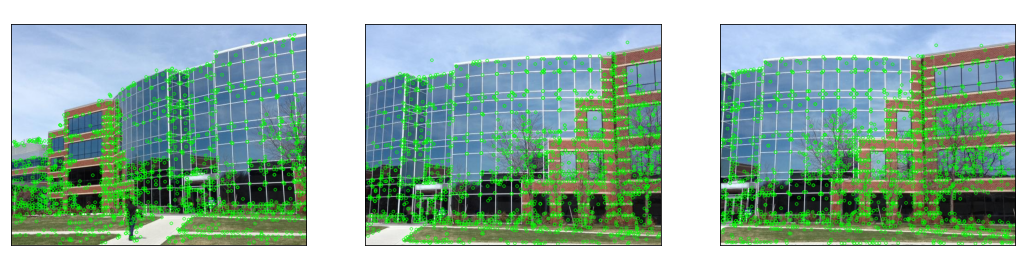

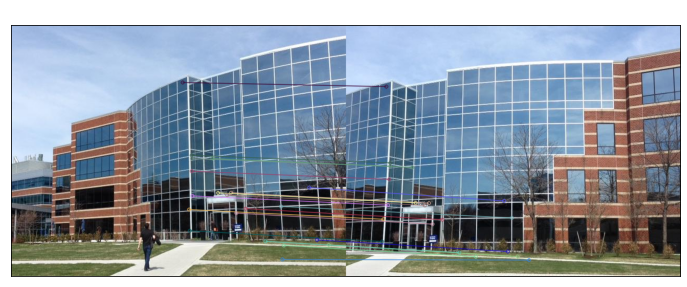

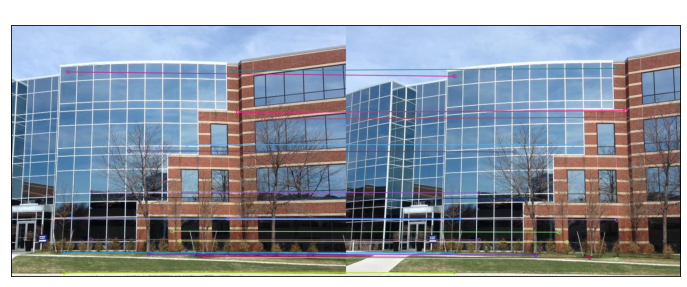

Computing the best homography matrix for images 1 and 2 using RANSAC...

Done! The best homography matrix for images 1 and 2: 

 [[ 3.00532273e-03  2.61361558e-04  9.98838070e-01]
 [-6.08228203e-04  3.63965192e-03  4.77899051e-02]
 [-1.52690655e-06 -8.59192176e-08  3.98972608e-03]]

Computing the best homography matrix for images 3 and 2 using RANSAC...

Done! The best homography matrix for images 3 and 2: 

 [[ 9.36930588e-03 -1.16476125e-04 -9.77097397e-01]
 [ 5.07461954e-04  9.03527299e-03 -2.12224694e-01]
 [ 1.40396781e-06  7.26829013e-08  8.46549783e-03]]


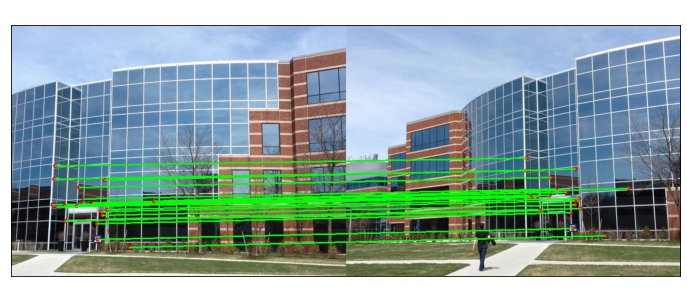

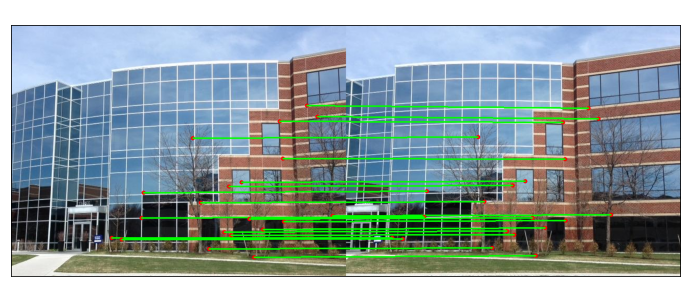


All computations done! Stitching the images...

Panoramic stitching complete!


In [24]:
# Calling the stitching function with verbose set to True for visualizations...
final_img = panoramic_stitching_multiple(img1, img2, img3, True)

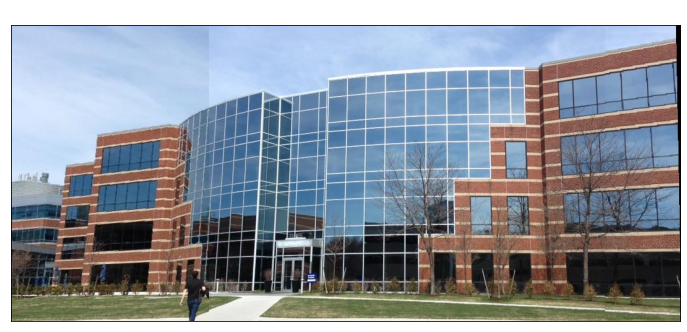

In [25]:
# Plotting the final output...
# Note that the final output still had some unnecessary black pixels so 
# I truncated the last 35 rows for a more aesthetically pleasing result.
# (Note : I arrived at 35 by trial and error)
plot_img(final_img[:-35,:,:],"Final Stitched Output")

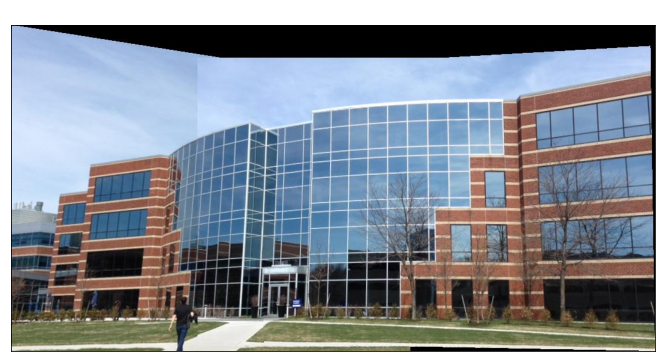

In [26]:
# Plotting the reference for checking...
plot_img(ref,"The reference image")

### NAME : R ADITHYA GOWTHAM
### ROLL NUMBER : EE17B146